# 用 qGAN 加載隨機分布

給定 $k$-維度的樣本資料，我們用 qGAN 來獲得資料的基礎隨機分布並將其直接加載到量子態 :

<center>$ {∣g_\theta⟩} = \sum_{j=0}^{2^n−1}\sqrt{p_θ^j}{∣j⟩}$</center>

$p_θ^j$ 代表了基本態 $∣j⟩$ 的發生機率。

qGAN 的訓練目標生成一個狀態 $∣g_\theta⟩$ 其中 $p_θ^j$ ($j∈\{{0,...,2^n−1}\}$)，代表一個機率分布其接近訓練資料 
$X = \{{x^0,...,x^k−1}\}$ 的基礎分布。

想要進一步了解請參考論文 "Quantum Generative Adversarial Networks for Learning and Loading Random Distributions Zoufal, Lucchi, Woerner [2019]"。

應用訓練過的 qGAN 的例子，金融衍生品的訂價，請參閱 "Option Pricing with qGANs" 的教學。

In [1]:
import pandas
import time
from scipy.stats import lognorm
from sklearn.preprocessing import StandardScaler
import numpy as np
seed = 71
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

from qiskit import Aer, QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
from qiskit.finance.applications import EuropeanCallExpectedValue

algorithm_globals.random_seed = seed

C:\Users\user\anaconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
C:\Users\user\anaconda3\lib\site-packages\qiskit\finance\__init__.py:50: DeprecationWarning: The package qiskit.finance is deprecated. It was moved/refactored to qiskit_finance (pip install qiskit-finance). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('finance', 'qiskit_finance', 'qiskit-finance')


## 載入訓練資料

首先，我們需要載入 $k$-維度的訓練資料樣本(在此 k=1)。

接下來，設置數據的解析度，也就是最大最小值和用於代表每個資料維度的量子位元數量。

In [2]:
# 訓練資料的樣本數
start = time.process_time()
N = 1000
qubits_num = 3

# 把高盛能源金屬指數的數據轉換成對數正態分布以找出平均值和標準差
data = []
data = pandas.read_csv("ttt.csv", names=["price"])
scaler = StandardScaler()
data_list = scaler.fit_transform(data) # 将数据更改使得数据可以被fit
print(data_list)
data_arr = np.array(data_list)
actual_data = data_arr.astype(float)

print("actual_data:",actual_data)
sigma,loc,scale = stats.lognorm.fit(actual_data)
estimated_mu = np.log(scale)
estimated_sigma = sigma
real_data = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
print("mu:{},sigma:{}".format(estimated_mu,estimated_sigma))

# 將數據標準化
Dmin = real_data.min()
Dmax = real_data.max()
# new_data = []
# for i in real_data:
#     new = (i - Dmin) / (Dmax - Dmin) * (2 ** qubits_num - 1)
#     new_data.append(new)
# #print(new_data)
print(Dmin,Dmax)
# real_data = new_data

# 根據資料的維度設置量子位元為 k 個量子位元串列[#q_0,...,#q_k-1]
load_num_qubits = [qubits_num]
k = len(load_num_qubits)

# 設置數據解析度
# 設置最高和最低資料數值作為 k 最小/最大數據值的串列
load_bounds = np.array([0, (2 ** load_num_qubits[0]) -1])

[[1.37844049]
 [1.31919497]
 [1.33795605]
 ...
 [0.74076116]
 [0.76208955]
 [0.7222963 ]]
actual_data: [[1.37844049]
 [1.31919497]
 [1.33795605]
 ...
 [0.74076116]
 [0.76208955]
 [0.7222963 ]]
mu:1.2542724636880587,sigma:0.2780874767952817
1.6600391918354007 7.937454830356145


## 初始化qGAN
qGAN 包括一個量子生成器 $G_\theta$ ，即是一個擬設，和一個經典判別器 $D_\phi$ ，一個神經網路。

為了執行量子生成器，我們選則一個深度-$1$ 實施了 $R_Y$ 旋轉和 $CZ$ 閘的擬設其以均勻分配為輸入態。 尤其是，若是 $k>1$ 的生成器參數必須小心的選擇。例如，電路的深度應該 $>1$ 因為更高的電路深度才能夠表示更複雜的結構。

使用的經典判別器是基於 NumPy 實施的神經網路。 還有一個判別器是基於 PyTorch 其並未於 Qiskit 默認的安裝內 - 更多資訊請參閱 Optional Install。

在此，兩個網路使用 ADAM 最佳化演算法(ADAM 是量子生成對抗網路的默認優化器)。

In [3]:
# 設置人工智慧訓練型樣的數量
# 記住:演算法的執行時間可以透過減少人工智慧訓練型樣的數量來降低
num_epochs = 5
# 批次量
batch_size = int(N/num_epochs)

# 初始化 qGAN
qgan = QGAN(real_data, load_bounds, load_num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 11
# 設置 quantum instance 以執行量子生成器
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'),
                                   seed_transpiler=seed, seed_simulator=seed)

# 為生成器電路設置初始態
init_dist = UniformDistribution(sum(load_num_qubits))

# 設置擬設電路
ansatz = TwoLocal(int(np.sum(load_num_qubits)), 'ry', 'cz', 'circular', reps=1, insert_barriers=True)

# 設置初始參數用於減少訓練時間進而降低筆記的執行時間
# 你可以提升人工智慧訓練型樣的數量並使用隨機初始參數
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
print(init_params)
# init_params = [100,100,100,100,100,100,100,100,100,100]
load_g_circuit = ansatz.compose(init_dist, front=True)

# 設置量子生成器
qgan.set_generator(generator_circuit=load_g_circuit, generator_init_params=init_params)
# 參數具有順序問題下列是暫時的解決方法
qgan._generator._free_parameters = sorted(load_g_circuit.parameters, key=lambda p: p.name)
# 設置經典判別器神經網路
discriminator = NumPyDiscriminator(len(load_num_qubits))
qgan.set_discriminator(discriminator)

C:\Users\user\anaconda3\lib\site-packages\qiskit\aqua\quantum_instance.py:135: DeprecationWarning: The class qiskit.aqua.QuantumInstance is deprecated. It was moved/refactored to qiskit.utils.QuantumInstance (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_class('aqua.QuantumInstance',


[1.21564296 5.94923134 4.20587794 1.32325767 3.8823082  2.17438522]


<ipython-input-3-e6db00abfdeb>:15: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(load_num_qubits))


## 執行qGAN的訓練

在訓練生成器和判別器時的參數是用以下的損失函數來交替更新:

<center>$L_G (\phi,\theta) = -\frac{1}{m}\sum_{l=1}^{m}[\log(D_\phi (g^l))]$</center>

以及

<center>$L_G (\phi,\theta) = \frac{1}{m}\sum_{l=1}^{m}[\log D_\phi (x^l) + \log(1 - D_\phi(g^l))]$</center>
 
$m$ 代表了批次而 $g^l$ 表示了量子生成器產生的資料樣本。

請記住此訓練，為了這次的筆記本，選擇已知的初始點以保持簡節. 沒有這樣的先前知識需要注意訓練可能會花一點時間。

In [4]:
# 執行 qGAN
result = qgan.run(quantum_instance)

In [5]:
print('Training results:')
for key, value in result.items():
    print(f'  {key} : {value}')

print(result['params_g'])

Training results:
  params_d : [-0.53387831  0.00066173  0.12816618 ...  0.06577865  0.0669668
 -0.18557944]
  params_g : [1.21563293 5.94923286 4.20587429 1.32326304 3.88230277 2.17438355]
  loss_d : 0.6735
  loss_g : [0.9209]
  rel_entr : 4.0346
[1.21563293 5.94923286 4.20587429 1.32326304 3.88230277 2.17438355]


## 訓練過程和結果

現在，我們繪製生成器和判別器的損失函數在訓練中的變化，以及訓練和目標分布的相對熵的進展。

最後，我們也比較訓練分布和目標分布的累積分布函數(CDF)。

[0.4189]


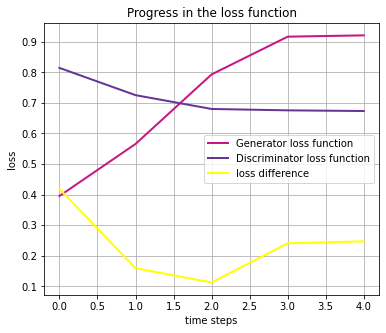

[array([0.3956]), array([0.5658]), array([0.7932]), array([0.9166]), array([0.9209])]
[0.8145, 0.7254, 0.6802, 0.6757, 0.6735]


In [6]:
# 繪製基於生成器和判別器的損失函數進展
t_steps = np.arange(num_epochs)
def func(aa,bb):
    return abs(aa-bb)
trytry = list(map(func, qgan.g_loss, qgan.d_loss))
print(trytry[0])
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.plot(t_steps, trytry, label='loss difference', color='yellow', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()
print(qgan.g_loss)
print(qgan.d_loss)

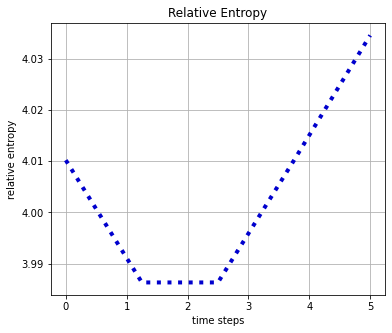

In [7]:
# 繪製基於相對熵的進展
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

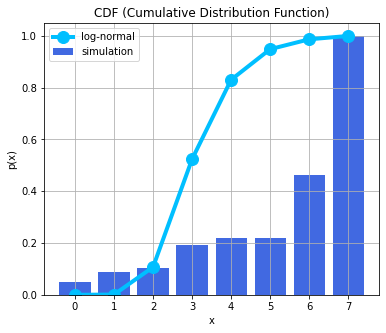

In [8]:
#繪製結果分布對於目標分布，也就是對數正態分布，的累積分布函數
log_normal = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=1000)

# 將數據標準化
# Dmin = log_normal.min()
# Dmax = log_normal.max()
# log_data = []
# for i in log_normal:
#     new = (i - Dmin) / (Dmax - Dmin) * (2 ** qubits_num - 1)
#     log_data.append(new)
# #print(new_data)
# log_normal = log_data

# print(log_normal)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= load_bounds[1]]

temp = []
for i in range(int(load_bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()


# 使用量子生成對抗網路為期權定價

## 簡介

#### 在此筆記本，我們討論量子機器學習，即量子生成對抗網路(qGAN)，如何促進歐洲看漲期權的定價。更具體的說，qGAN可以訓練成量子電路模擬歐洲看漲期權基礎資產的現貨價格。由此得到的模型可以集成到基於量子振幅估計的算法中，以評估預期的收益-參見歐洲看漲期權定價。關於通過訓練qGAN學習和加載隨機分佈的更多細節，請參閱論文''Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.''

##  不确定性模型 Uncertainty Model
#### Black-Scholes模型假設歐洲看漲期權在到期時 $S_T$ 的現貨價格是對數正態分佈的。因此，我們可以用來自對數正態分佈的樣本訓練qGAN，並將結果作為基於期權的不確定性模型。接下来，我們構建一個量子電路用於加載不確定性模型。電路輸出如下
44
<center>$ {∣g_\theta⟩} = \sum_{j=0}^{2^n−1}\sqrt{p_θ^j}{∣j⟩}$</center>

#### 其中概率 $p_θ^j$ ($j∈{0，…，2n−1}$)，表示目標分佈模型。

In [9]:
# 設置最高、最低數據值
op_bounds = np.array([0 , (2 ** load_num_qubits[0]) -1])
# 不確定性模型中使用的量子位元的集合數
op_num_qubits = load_num_qubits[0]

# 加載訓練過的電路參數
g_params = result['params_g']
print(g_params)
# g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]
# 為生成器電路設置初始態
init_dist = NormalDistribution(op_num_qubits, mu=estimated_mu, sigma=estimated_sigma, bounds=op_bounds)

# 構造變分形式
var_form = TwoLocal(op_num_qubits, 'ry', 'cz', entanglement='circular', reps=1)

# 保留一個參數列表，以便我們可以將它們與數值列表關聯起來
# (否則我們需要一個字典)
theta = var_form.ordered_parameters

# 組成生成器電路，這是加載不確定性模型的電路
op_g_circuit = init_dist.compose(var_form)

print(dict(zip(theta, g_params)))

[1.21563293 5.94923286 4.20587429 1.32326304 3.88230277 2.17438355]
{ParameterVectorElement(θ[0]): 1.215632930222219, ParameterVectorElement(θ[1]): 5.9492328583177585, ParameterVectorElement(θ[2]): 4.205874291183962, ParameterVectorElement(θ[3]): 1.3232630412892985, ParameterVectorElement(θ[4]): 3.882302765492633, ParameterVectorElement(θ[5]): 2.174383546870831}


<ipython-input-9-65c9be20369a>:11: DeprecationWarning: `NormalDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.NormalDistribution.
  init_dist = NormalDistribution(op_num_qubits, mu=estimated_mu, sigma=estimated_sigma, bounds=op_bounds)


## 評估預期收益

#### 現在，訓練的不確定性模型可以用量子振幅估計來評估期權收益函數的期望值。

In [10]:
# 設置執行價格(應該在不確定性的最低值和最高值範圍內)
strike_price = 2

# 設置成本函數的近似縮放
c_approx = 0.25

# 為成本函數構造電路
european_call_objective = EuropeanCallExpectedValue(
    op_num_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=op_bounds
)

## 繪製概率分佈

##### 接下來，我們繪製訓練後的概率分佈圖，為了便於比較，我們也繪製目標概率分佈圖。

[ 0.01745421+0.j  0.46524736+0.j  0.10894112+0.j -0.34191062+0.j
 -0.12168045+0.j -0.41091422+0.j -0.52719743+0.j  0.43917587+0.j]


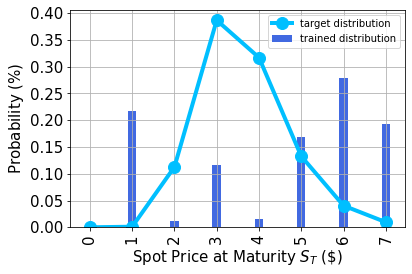

In [11]:
# 評估訓練過的概率分佈
values = [op_bounds[0] + (op_bounds[1] - op_bounds[0]) * x / (2 ** op_num_qubits - 1) for x in range(2**op_num_qubits)]
uncertainty_model = op_g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data
print(amplitudes)

x = np.array(values)
# print(x)
y = np.abs(amplitudes) ** 2
# print(y)

# 從目標概率分佈中抽取樣本
N = 100000
log_normal = np.random.lognormal(mean=estimated_mu, sigma=estimated_sigma, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= (2 ** op_num_qubits) -1]
log_normal_samples = []
for i in range(2 ** op_num_qubits):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# 繪製分布
plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

## 評估預期收益

#### 現在，訓練的不確定性模型可以用量子振幅估計的方法解析求解期權收益函數的期望值。

[0.         0.0010935  0.11268058 0.3866874  0.31691413 0.1325943
 0.04045947 0.00957063]
[0.00030465 0.21645511 0.01186817 0.11690287 0.01480613 0.16885049
 0.27793714 0.19287544]
8
[0 0 0 1 2 3 4 5]
Analytically calculated expected payoff w.r.t. the target distribution:  1.6280
Analytically calculated expected payoff w.r.t. the trained distribution: 2.7292


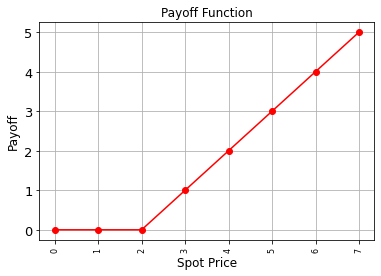

In [12]:
# 評估不同發行版本的收益
print(log_normal_samples)
print(y)
print(len(y))
payoff = []
for i in range(2 ** op_num_qubits):
    if i <= strike_price:
        payoff.append(0)
    else:
        payoff.append(i - strike_price)
payoff = np.array(payoff)
print(payoff)

ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# 繪製精確的收益函數(在訓練的不確定性模型的網格上進行評估)
x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=12)
plt.xlabel('Spot Price', size=12)
plt.ylabel('Payoff', size=12)
plt.xticks(x, size=8, rotation=90)
plt.yticks(size=13)
plt.show()

In [13]:
# 為QAE構造一個操作符
european_call = european_call_objective.compose(uncertainty_model, front=True)

In [14]:
# 設置目標精度和信賴區間
epsilon = 0.01
alpha = 0.05

# 構造振幅估計
ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha,
                                  state_preparation=european_call,
                                  objective_qubits=[op_num_qubits],
                                  post_processing=european_call_objective.post_processing)

C:\Users\user\anaconda3\lib\site-packages\qiskit\aqua\algorithms\amplitude_estimators\ae_algorithm.py:91: DeprecationWarning: The package qiskit.aqua.algorithms.amplitude_estimators is deprecated. It was moved/refactored to qiskit.algorithms.amplitude_estimators (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.algorithms.amplitude_estimators',


In [15]:
END_result = ae.run(quantum_instance = Aer.get_backend('qasm_simulator'), shots = 1000)

C:\Users\user\anaconda3\lib\site-packages\qiskit\utils\deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


In [16]:
conf_int = np.array(END_result['confidence_interval'])
print('Target value:       \t%.4f' % ep)
print('Exact value:        \t%.4f' % ep_trained)
print('Estimated value:    \t%.4f' % (END_result['estimation']))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

end = time.process_time()

print("執行時間：%f 秒" % (end - start))
print(g_params)

Target value:       	1.6280
Exact value:        	2.7292
Estimated value:    	2.7352
Confidence interval:	[2.6854, 2.7850]
執行時間：20.562500 秒
[1.21563293 5.94923286 4.20587429 1.32326304 3.88230277 2.17438355]
